In [1]:
import sys

sys.path.append("/home/jupyter/work/resources/DiplomDimReduction/")
import importlib

import config

importlib.reload(config)
import utils
from config import config_dict

importlib.reload(utils)
from itertools import combinations

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import friedmanchisquare, wilcoxon
from sklearn.metrics import ndcg_score
from statsmodels.stats.multitest import multipletests
from utils import create_path, load_metrics

In [164]:
red_dims = [512, 256, 128, 64]
current_dim = 256

In [165]:
# model_name = config_dict["dpr_model"]
# method_prefix = config_dict["dpr_prefix"]

# model_name = config_dict['ance_model']
# method_prefix = config_dict['ance_prefix']

model_name = config_dict["tas-b_model"]
method_prefix = config_dict["tas-b_prefix"]

# model_name = config_dict['s-bert_model']
# method_prefix = config_dict['s-bert_prefix']

corpus_prefix = config_dict["marco_prefix"]

ndcgs_path_template = config_dict["ndcgs_template"]

boxplot_all_path = config_dict["boxplot_all_template"].format(
    corpus_prefix, method_prefix, current_dim
)

boxplot_umaps_path = config_dict["boxplot_umaps_template"].format(
    corpus_prefix, method_prefix, current_dim
)

In [166]:
methods = ["PCA", "UMAP", "UMAP_5", "UMAP_25", "LinearAutoencoder", "AutoEncoder+"]
main = ["PCA", "UMAP", "LinearAutoencoder", "AutoEncoder+"]
umaps = ["UMAP", "UMAP_5", "UMAP_25"]

In [167]:
dims_ndcgs = {}

for red_dim in red_dims:
    print(red_dim)
    dim_ndcgs = {}

    for method in methods:
        ndcgs_path = ndcgs_path_template.format(corpus_prefix, method_prefix, method)
        ndcgs = load_metrics(ndcgs_path)
        dim_ndcgs[method] = ndcgs[str(red_dim)]["ndcgs"]

    statistic, pvalue = friedmanchisquare(*[dim_ndcgs[method] for method in methods])
    print(f"all: statistic={statistic}, pvalue={pvalue}")

    statistic, pvalue = friedmanchisquare(*[dim_ndcgs[method] for method in main])
    print(f"main: statistic={statistic}, pvalue={pvalue}")

    statistic, pvalue = friedmanchisquare(*[dim_ndcgs[method] for method in umaps])
    print(f"umap: statistic={statistic}, pvalue={pvalue}")

    dims_ndcgs[red_dim] = dim_ndcgs

512
all: statistic=45.50155520995337, pvalue=1.1471711127930146e-08
main: statistic=16.04854368932041, pvalue=0.0011082912868490519
umap: statistic=1.8732394366197054, pvalue=0.3919505017110401
256
all: statistic=57.74806201550387, pvalue=3.545297812013426e-11
main: statistic=18.636075949367058, pvalue=0.00032509484798081756
umap: statistic=5.465753424657497, pvalue=0.06503194213514507
128
all: statistic=40.35222052067381, pvalue=1.2679947616885938e-07
main: statistic=16.91304347826085, pvalue=0.0007364487053090755
umap: statistic=1.581081081081118, pvalue=0.4535995400625503
64
all: statistic=25.660583941605875, pvalue=0.00010382885981626594
main: statistic=12.42737430167591, pvalue=0.006053751567419508
umap: statistic=1.7051282051281933, pvalue=0.4263204000714581


In [168]:
def compare_pairs(df, columns=[], correct=False):
    if not columns:
        columns = df.columns

    pairs = list(combinations(columns, 2))
    p_values = []
    comparisons = []
    reject = []

    for m1, m2 in pairs:
        stat, pval = wilcoxon(df[m1], df[m2])
        p_values.append(pval)
        comparisons.append(f"{m1} vs {m2}")
        if pval > 0.05:  # TODO: a ровно?
            reject.append(False)
        else:
            reject.append(True)

    print("Попарные сравнения Wilcoxon без поправки")
    for comp, pval, rej in zip(comparisons, p_values, reject):
        print(f"{comp}: raw p = {pval:.5f}, reject H0: {rej}")

    if len(columns) > 2:
        correct = True

    if correct:
        print()

        reject, p_corrected, _, _ = multipletests(p_values, method="holm")
        print("Попарные сравнения Wilcoxon с поправкой Holm:")
        for comp, p_corr, rej in zip(comparisons, p_corrected, reject):
            print(f"{comp}: corrected p = {p_corr:.5f}, reject H0: {rej}")

        print()

        reject, p_corrected, _, _ = multipletests(p_values, method="fdr_bh")
        print("Попарные сравнения Wilcoxon с поправкой Benjamini–Hochberg:")
        for comp, p_corr, rej in zip(comparisons, p_corrected, reject):
            print(f"{comp}: corrected p = {p_corr:.5f}, reject H0: {rej}")

In [169]:
df = pd.DataFrame(dims_ndcgs[current_dim])
df.describe()

,PCA,UMAP,UMAP_5,UMAP_25,LinearAutoencoder,AutoEncoder+
count,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000
mean,0.865384,0.765827,0.748395,0.727728,0.870525,0.860066
std,0.166558,0.171553,0.173735,0.168731,0.163108,0.162259
min,0.445734,0.424960,0.424960,0.440119,0.464854,0.479235
25%,0.752564,0.621977,0.626366,0.572607,0.770038,0.712263
50%,0.946902,0.732829,0.752972,0.712263,0.946902,0.932521
75%,1.000000,0.922961,0.906628,0.863933,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


/home/jupyter/work/resources/DiplomDimReduction/data/plots/marco/tas_b exists.


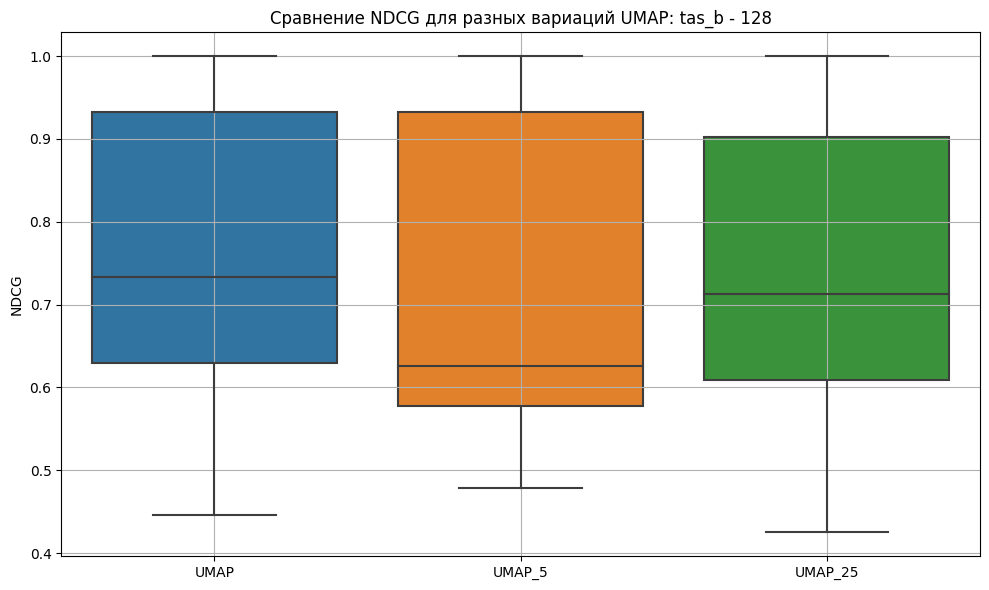

In [162]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[umaps])
plt.title(f"Сравнение NDCG для разных вариаций UMAP: {method_prefix} - {current_dim}")
plt.ylabel("NDCG")
plt.xticks(rotation=0)
plt.grid(True)
plt.tight_layout()
create_path(boxplot_umaps_path)
plt.savefig(boxplot_umaps_path)
plt.show()

/home/jupyter/work/resources/DiplomDimReduction/data/plots/marco/tas_b exists.


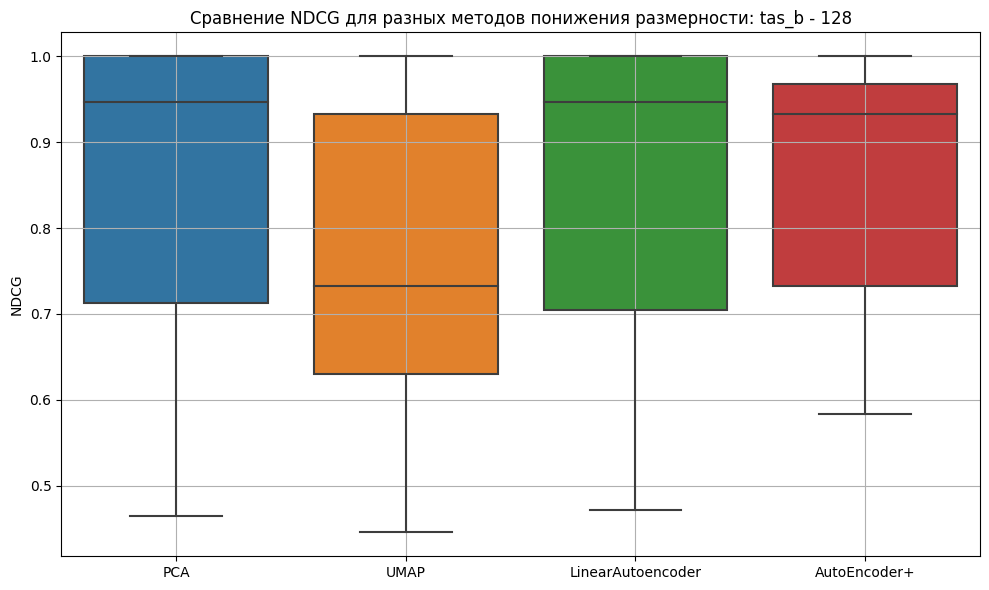

In [163]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[main])
plt.title(
    f"Сравнение NDCG для разных методов понижения размерности: {method_prefix} - {current_dim}"
)
plt.ylabel("NDCG")
plt.xticks(rotation=0)
plt.grid(True)
plt.tight_layout()
create_path(boxplot_all_path)
plt.savefig(boxplot_all_path)
plt.show()

In [154]:
compare_pairs(df, columns=umaps)

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Попарные сравнения Wilcoxon без поправки
UMAP vs UMAP_5: raw p = 0.30291, reject H0: False
UMAP vs UMAP_25: raw p = 0.08986, reject H0: False
UMAP_5 vs UMAP_25: raw p = 0.66618, reject H0: False

Попарные сравнения Wilcoxon с поправкой Holm:
UMAP vs UMAP_5: corrected p = 0.60582, reject H0: False
UMAP vs UMAP_25: corrected p = 0.26959, reject H0: False
UMAP_5 vs UMAP_25: corrected p = 0.66618, reject H0: False

Попарные сравнения Wilcoxon с поправкой Benjamini–Hochberg:
UMAP vs UMAP_5: corrected p = 0.45437, reject H0: False
UMAP vs UMAP_25: corrected p = 0.26959, reject H0: False
UMAP_5 vs UMAP_25: corrected p = 0.66618, reject H0: False


/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


In [155]:
compare_pairs(df, columns=main)

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Попарные сравнения Wilcoxon без поправки
PCA vs UMAP: raw p = 0.21768, reject H0: False
PCA vs LinearAutoencoder: raw p = 0.01835, reject H0: True
PCA vs AutoEncoder+: raw p = 0.01199, reject H0: True
UMAP vs LinearAutoencoder: raw p = 0.06238, reject H0: False
UMAP vs AutoEncoder+: raw p = 0.01273, reject H0: True
LinearAutoencoder vs AutoEncoder+: raw p = 0.06014, reject H0: False

Попарные сравнения Wilcoxon с поправкой Holm:
PCA vs UMAP: corrected p = 0.21768, reject H0: False
PCA vs LinearAutoencoder: corrected p = 0.07340, reject H0: False
PCA vs AutoEncoder+: corrected p = 0.07193, reject H0: False
UMAP vs LinearAutoencoder: corrected p = 0.18042, reject H0: False
UMAP vs AutoEncoder+: corrected p = 0.07193, reject H0: False
LinearAutoencoder vs AutoEncoder+: corrected p = 0.18042, reject H0: False

Попарные сравнения Wilcoxon с поправкой Benjamini–Hochberg:
PCA vs UMAP: corrected p = 0.21768, reject H0: False
PCA vs LinearAutoencoder: corrected p = 0.03670, reject H0: True
PCA 

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if ther